In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

#Polynomial Chaos E. terms ----------------------------------------------

def hermite(x,n):
    if n==0:
        return 1
    elif n==1:
        return x
    elif n==2:
        return (x**2-1)/(np.sqrt(2))
    elif n==3:
        return (x**3-3*x)/(np.sqrt(6))
    elif n==4:
        return (x**4-6*x**2+3)/(np.sqrt(24))
    elif n==5:
        return (x**5-10*x**3+15*x)/(np.sqrt(120))

def legendre(x,n):
    if n==0:
        return 1
    elif n==1:
        return x*(np.sqrt(3))
    elif n==2:
        return (3*x**2-1)*(np.sqrt(5))/2
    elif n==3:
        return (5*x**3-3*x)*(np.sqrt(7))/2
    elif n==4:
        return (35*x**4-30*x**2+3)*(np.sqrt(9))/8
    elif n==5:
        return (63*x**5-70*x**3+15*x)*(np.sqrt(11))/8  
    
def scalelegendre(x,new_min,new_max): 
    return ((new_min+new_max)+((new_max-new_min)*x))/2

def scalehermite(x,mean,sigma):
    return mean+sigma*x

def PCE(x1,x2,alpha,Y_):
    M_= 0
        
    for j in range (0,len(alpha)):
           
        M_ = M_ + Y_[j] * M1(x1,alpha[j,0]) * M2(x2,alpha[j,1])  #M1 legendre / M2 hermite

    return M_

#Kriging ----------------------------------------------

def distance1D(x,xk):
    return x.reshape(-1,1)-xk.reshape(1,-1)

def distance(x,xk):                        #multidimensional distance between 2 samples
    d=np.zeros((len(x),len(xk)))
    
    for j in range(0,len(xk)):
        for i in range(0,len(x)):
            d[i,j] = d[i,j]+np.sqrt(np.sum((x[i]-xk[j])**2))
    return d

def euclid(r,l,scale):   # kernell squared Euclidean distance
    return scale*np.exp(-((r)**2/(2*l**2)))

def GaussianPred(x,xn,yn,phi,Y,l,sig):
    
    cov_nn = euclid(distance(xn,xn),l,sig)             #covariance between observations
    cov_xn = euclid(distance(x,xn),l,sig)              #covariance with new points
    cov_mult=np.matmul(cov_xn,np.linalg.inv(cov_nn))   #  r'(x) * R^-1
    #--------------------------------------------------------------------------------------    
    mean=np.matmul(cov_mult,(yn-np.matmul(phi,Y)))     #mean corrected by PCE
    #-------------------------------------------------------------------------------------- 
    cov_xx=euclid(distance(x,x),l,sig)
    variance=np.subtract(cov_xx,np.matmul(cov_mult,cov_xn.transpose())) 
    variaDiag=np.diagonal(variance)
    
    return [mean,variaDiag];

# def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [1D array]
#     dist=abs(distance(x,xn))
#     voro=np.argmin(np.squeeze(dist))
#     return voro

In [2]:
#ground truth function----------------------------------------------------

def function(x1,x2):
#     return x**0.5*np.sin(x)
#     return -(np.sin(x1*7)+np.cos(14*x2))*(x1**2)*np.exp(-4*x2)
    return 1- (x1**2 + x2**2)

In [3]:
#definition of input parameters----------------------------------------------

dim=2       # dimensionality
n=10        # observations

np.random.seed(0)         #fixing seed random number generator

#-----------------------------------------------------random Variable 1
x1 = np.random.uniform(-1,1,n)      #uniform
x1min = 0                           #lower bound    
x1max = 1.5                         #upper bound
x1r = scalelegendre(x1,x1min,x1max) #values to evaluate real function
M1=legendre                         #type of polynomial for PCE
#-----------------------------------------------------random Variable 2
x2=np.random.normal(0,1,n)           #normal
x2mean= 0.7                          #mean 
x2sigma= 0.3                         #standard deviation
x2r=scalehermite(x2,x2mean,x2sigma)  #values to evaluate real function
M2=hermite                           #type of polynomial for PCE
#=====================================================
#=====================================================
y=function(x1r,x2r)          #Observations

In [4]:
#truncation term
p = 2   #for each variable → same truncation , degree of expansion

indices = np.arange(0,p+1)   #polynomials indices to be combined

A1 = np.zeros((n, p+1))
A2 = np.zeros((n, p+1))
comb = np.zeros((p**dim,dim))

#evaluation of all orthogonal polynomials with degree < p for each variable

for i in range (0,n):
    for j in range (0,p+1):
        A1[i,j] = np.array([M1(x1[i],j)])

for i in range (0,n):
    for j in range (0,p+1):
        A2[i,j] = np.array([M2(x2[i],j)])
#------------------------------------------------------------------------- #all possible combinations of indices
comb = np.array(np.meshgrid(indices,indices)).T.reshape(-1,dim)    

alpha = [] #list of product combinations with degree <= "p" (truncation term)

for i in range (0,len(comb)): 
    if (np.sum(comb[i]))<=p:  
        alpha.append(comb[i])
        
alpha = np.array(alpha) #alpha for multivariate combination

#EXPERIMENTAL MATRIX == evaluation of product combinations for multivariate function with degree <= "p"

phi = np.zeros((n, len(alpha)))

for i in range (0,n):
    for j in range (0,len(alpha)):
        phi[i,j]=A1[i,alpha[j,0]]*A2[i,alpha[j,1]]
        
#Learning coefficients by Least-Square Minimization based experimental matrix

phi_trans=phi.transpose()
phi_Inv=np.linalg.inv(np.matmul(phi_trans, phi))
Inv_phi_trans=np.matmul(phi_Inv,phi_trans)
Y_=np.matmul(Inv_phi_trans,y)                         #coefficients for PC =f(M) observations

5.9557766711986956e-27
-0.32999999999999874 -0.3101469511449344


<IPython.core.display.Javascript object>


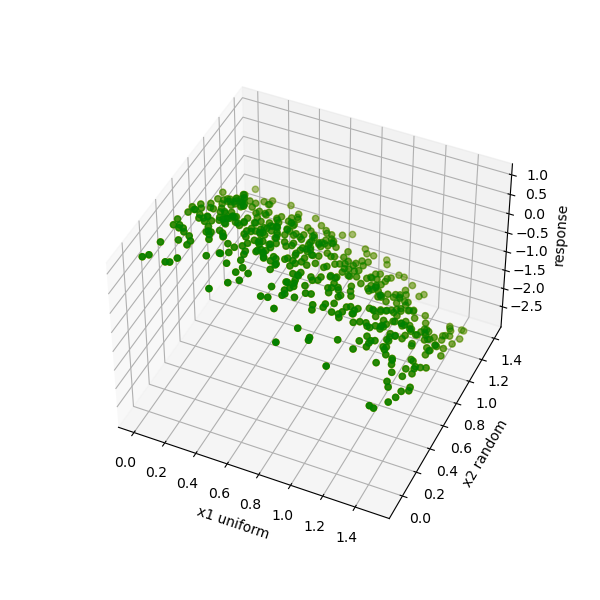

Text(0.5, 0, 'response')

In [7]:
ntest=500

#normalized inputs for PCE evaluation
X1=np.random.uniform(-1,1,ntest)        
X2=np.random.normal(0,1,ntest)

#real inputs for real function evaluation
X1r=scalelegendre(X1,x1min,x1max)       
X2r=scalehermite(X2,x2mean,x2sigma)

Mtest=function(X1r,X2r)

M=PCE(X1,X2,alpha,Y_)        #predictions on calibrated Y_ coefficients

MSE_pc=np.sum((Mtest-M)**2)  #MSError - global
print(MSE_pc)
print(Y_[0],np.mean(Mtest))  #Coefficient_0 vs mean

%matplotlib notebook 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1r,X2r,Mtest, color='green')
# ax.scatter(x1r,x2r,y, 'r')
ax.scatter(X1r,X2r,M, color='orange') 
ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')

# Kriging Model - 2 input var

In [10]:
xn=np.stack((x1,x2),axis=1)             #Single array for input variables/observations in hermite/legendre ranges
xr=np.stack((x1r,x2r),axis=1)           #Single array for input variables/observations
XR=np.stack((X1r,X2r),axis=1)           #Single array for testing variables

#optimizing kernell-hyperparameters and fitting GP regressor with Scikit-learn package----------------------------
kernel = 1 * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(xr, y)
ke= gaussian_process.kernel_
print("kernel 1   :",ke)

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel 1   : 33**2 * RBF(length_scale=6.86)


In [14]:
# kernel hyperparameters------------------------------
l=6.91        #length scale
sig=33.4**2   #

#-----------------------------------------------------COVARIANCE matrices
cov_nn = euclid(distance(xr,xr),l,sig)    #covariance between observations
cov_xn = euclid(distance(XR,xr),l,sig)    #covariance with new points

cov_mult=np.matmul(cov_xn,np.linalg.inv(cov_nn))   #  r'(x) * R^-1
KrigMean=np.matmul(cov_mult,(y))         #Zero prior mean GP

#Variance prediction -------------------------------------------------

cov_xx=euclid(distance(XR,XR),l,sig)
variance=np.subtract(cov_xx,np.matmul(cov_mult,cov_xn.transpose())) 
variaDiag=np.diagonal(variance)    #extracting main diagonal 

# graph_scale = 5
# ymin=(PCK - graph_scale*variaDiag).reshape(-1,1)        #to plot + variance 
# ymax=(PCK + graph_scale*variaDiag).reshape(-1,1)        #to plot - variance 

MSE_krig 0.03304431727940562


<IPython.core.display.Javascript object>


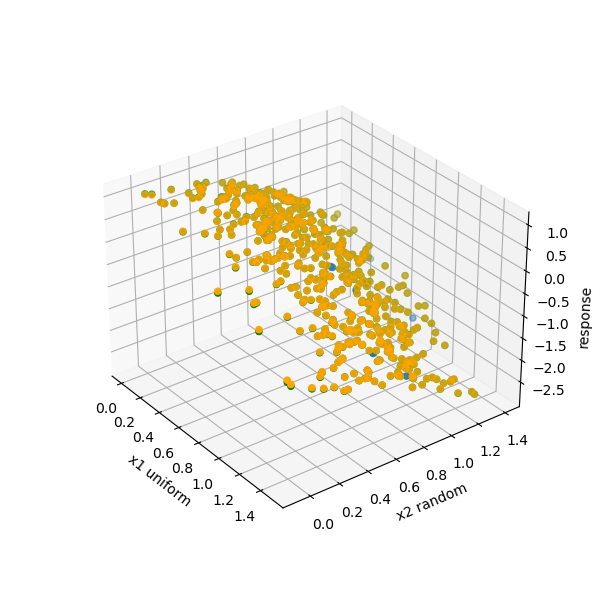

Text(0.5, 0, 'response')

In [15]:
MSE_krig=np.sum((Mtest-KrigMean)**2)  #MSError - global
print('MSE_krig',MSE_krig)

%matplotlib notebook 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1],Mtest, color='green')
ax.scatter(xr[:,0],xr[:,1],y, 'blue')
ax.scatter(XR[:,0],XR[:,1],KrigMean, color='orange') 
ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')

In [10]:
# #KRIGING SCIKIT LEARN---------------------------------------------------------------------
# mean_prediction, std_prediction = gaussian_process.predict(XR, return_std=True)

# MSE_krig_scik=np.sum((Mtest-mean_prediction)**2)
# print(MSE_krig_scik)


# %matplotlib notebook 
# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(XR[:,0],XR[:,1],Mtest, color='green')
# ax.scatter(xr[:,0],xr[:,1],y, 'blue')
# ax.scatter(XR[:,0],XR[:,1],mean_prediction, color='orange') 
# ax.set_xlabel('x1 uniform')
# ax.set_ylabel('x2 random')
# ax.set_zlabel('response')

# PC-Kriging - 2 input var

MSE_PCK 4.389096053468071e-23


<IPython.core.display.Javascript object>


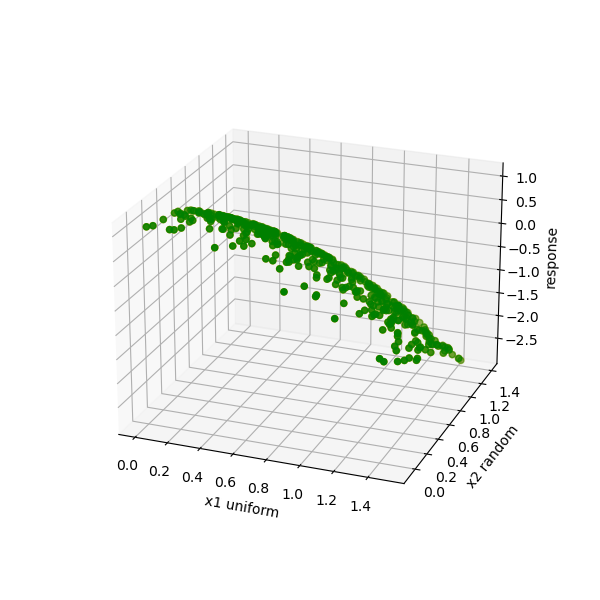

Text(0.5, 0, 'response')

In [16]:
FB=np.matmul(phi,Y_)    #------------------------------  mean correction by PCE

KrigMean_corr=np.matmul(cov_mult,(y-FB))   #updated GP mean prediction

PCK=M+KrigMean_corr

#Global MSError -------------------------------------------------
MSE_PCK=np.sum((Mtest-PCK)**2)
print('MSE_PCK',MSE_PCK)

#Plot -------------------------------------------------
%matplotlib notebook 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1],Mtest, color='green')
ax.scatter(XR[:,0],XR[:,1],PCK, color='orange')
# ax.scatter(xr[:,0],xr[:,1],y, 'blue')
# ax.scatter(XR[:,0],XR[:,1],ymin, color='gray')    #variance prediction is required
# ax.scatter(XR[:,0],XR[:,1],ymax, color='gray')

ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')

# LeaveOneOut_CrossValidation

In [17]:
PC_loo=np.zeros(n)
KrigMeanloo=np.zeros(n)
KrigVarloo=np.zeros(n)
PC_looALL=np.zeros((n,ntest))
KrigMeanlooALL=np.zeros((n,ntest))
KrigVarlooALL=np.zeros((n,ntest))

#Generating PCK models for each reduced design of experiments 
for i in range (0,n):             
    y_loo=np.delete(y,[i])                              #y_n-i     leaving element i out the observations (M)
    xr_loo=np.delete(xr,[i*2,i*2+1]).reshape(-1,2)      #x1r_n-i   leaving element i out the hermite inputs (xi)
    xn_loo=np.delete(xn,[i*2,i*2+1]).reshape(-1,2)      #x_n-i     leaving element i out the inputs (xi)

    #Sampling matrix (A matrix) evaluation of the samples in a sparse p polynomials matrix from PCE
   
    A1_loo = np.zeros((n-1, p+1))
    A2_loo = np.zeros((n-1, p+1))
    phi_loo = np.zeros((n-1, len(alpha)))
    
    #generation of all orthogonal polynomials with degree smaller than p for each variable

    for j in range (0,n-1):
        for k in range (0,p+1):
            A1_loo[j,k] = np.array([M1(xn[j,0],k)])    #legendre

    for j in range (0,n-1):
        for k in range (0,p+1):
            A2_loo[j,k] = np.array([M2(xn[j,1],k)])    #hermite
    #-------------------------------------------------------------------------
    #Learning coefficients by Least-Square Minimization
    
    for j in range (0,n-1):
        for k in range (0,len(alpha)):
            phi_loo[j,k]=A1[j,alpha[k,0]]*A2[j,alpha[k,1]]  

    phi_tr_loo=phi_loo.transpose()
    phi_Inv_loo=np.linalg.inv(np.matmul(phi_tr_loo, phi_loo))
    Inv_phi_trans_loo=np.matmul(phi_Inv_loo,phi_tr_loo)
    Y_loo=np.matmul(Inv_phi_trans_loo,y_loo)     #coefficients for PC =f(M) observations
            
    # PCE mean prediction --------------leaving i-term out
    PC_loo[i] = PCE(xn[i,0],xn[i,1],alpha,Y_loo)       #Predictions on single i-point out following coefficients LOO
    PC_looALL[i] = PCE(X1,X2,alpha,Y_loo)              #Predictions on ALL test points following coefficients LOO
    
    # KRIGING mean--------------leaving i-term out
    [KrigMeanloo[i],KrigVarloo[i]]=GaussianPred(xr[i].reshape(-1,2),xr_loo,y_loo,phi_loo,Y_loo,l,sig)    #Predictions on single i-point out following coefficients LOO
    [KrigMeanlooALL[i],KrigVarlooALL[i]]=GaussianPred(XR,xr_loo,y_loo,phi_loo,Y_loo,l,sig)                      #Predictions on ALL test points following coefficients LOO
    
mean_loo=PC_loo+KrigMeanloo
# e_loo=(M-mean_loo)**2
# sumat=np.divide(e_loo,KrigVarloo)
mean_looALL=PC_looALL+KrigMeanlooALL

# LOOCV=np.zeros(predict)
# cell=np.zeros(predict)
# for k in range (0,predict):  
#     voro = VoronoiCell(t2[k],xn)
#     LOOCV[k]= variaDiag[k]*(1+sumat[voro])
# #     cell[k] = voro

<IPython.core.display.Javascript object>


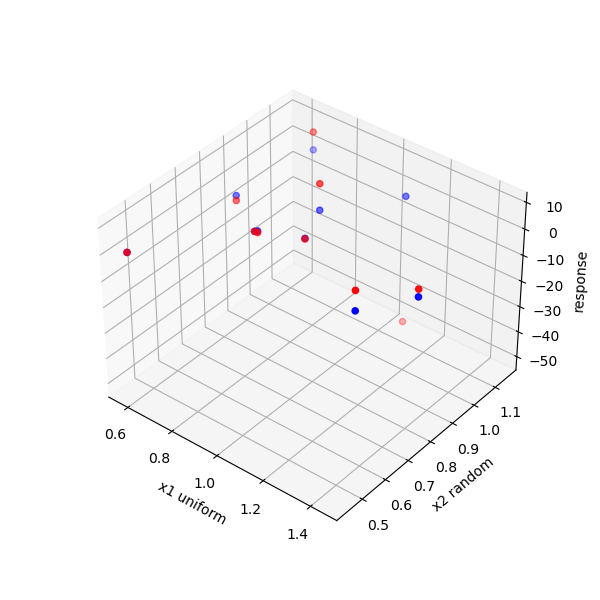

Text(0.5, 0, 'response')

In [18]:
#Plot -------------------------------------------------
%matplotlib notebook
# i=3                         # i-out observation to see the response surface shape

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xr[:,0],xr[:,1],y, color='blue')                 #observations
ax.scatter(xr[:,0],xr[:,1],mean_loo, color='red')           #leave-one-out predictions
# ax.scatter(X1r,X2r,mean_looALL[i], color='red')           #to plot the response surface shape leaving i out
ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')